In [1]:
import os
import networkx as nx
import numpy as np
from epynet import Network

import sys
sys.path.insert(0, os.path.join('..', 'utils'))
from graph_utils import get_nx_graph
from DataReader import DataReader
from baselines import interpolated_regularization

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
wds_id = 'anytown'
obsrat = .1

In [3]:
path_to_data = os.path.join('..', 'data', 'db_'+wds_id+'_doe_pumpfed_1')
path_to_wds = os.path.join('..', 'water_networks', wds_id+'.inp')

# Loading data
### Loading graph

In [4]:
wds = Network(path_to_wds)
G_unweighted = get_nx_graph(wds, mode='binary')
L_unweighted = np.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_unweighted).todense())
L_unweighted_normalized = np.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_unweighted).todense())
G_weighted = get_nx_graph(wds, mode='weighted')
L_weighted = np.array(nx.linalg.laplacianmatrix.laplacian_matrix(G_weighted).todense())
L_weighted_normalized = np.array(nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_weighted).todense())

### Loading signal

In [5]:
reader = DataReader(path_to_data, n_junc=len(wds.junctions.uid), obsrat=obsrat, seed=1234)
X_complete, _, _ = reader.read_data(
    dataset = 'tst',
    varname = 'junc_heads',
    rescale = 'standardize',
    cover = False
)
X_sparse, bias, scale = reader.read_data(
    dataset = 'tst',
    varname = 'junc_heads',
    rescale = 'standardize',
    cover = True
)

# Graph signal processing
### Smoothness

In [6]:
X = X_complete[:,:,0].T
smoothness_unweighted = np.dot(X.T, np.dot(L_unweighted, X)).trace()
smoothness_weighted = np.dot(X.T, np.dot(L_weighted, X)).trace()
smoothness_unweighted_normalized = np.dot(X.T, np.dot(L_unweighted_normalized, X)).trace()
smoothness_weighted_normalized = np.dot(X.T, np.dot(L_weighted_normalized, X)).trace()

In [7]:
print('Smoothness with unweighted Laplacian: {:.0f}.'.format(smoothness_unweighted))
print('Smoothness with weighted Laplacian: {:.0f}.'.format(smoothness_weighted))
print('Smoothness with normalized unweighted Laplacian: {:.0f}.'.format(smoothness_unweighted_normalized))
print('Smoothness with normalized weighted Laplacian: {:.0f}.'.format(smoothness_weighted_normalized))

Smoothness with unweighted Laplacian: 14182.
Smoothness with weighted Laplacian: 2665.
Smoothness with normalized unweighted Laplacian: 4786.
Smoothness with normalized weighted Laplacian: 5191.


### Spectrum

In [8]:
eigvals_weighted = np.linalg.eigvals(L_weighted_normalized).real
eigvals_unweighted = np.linalg.eigvals(L_unweighted_normalized).real

<BarContainer object of 22 artists>

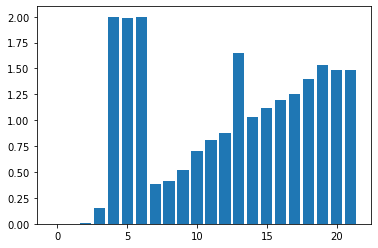

In [9]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_weighted)

<BarContainer object of 22 artists>

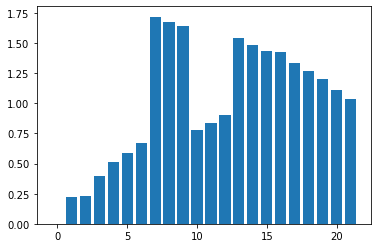

In [10]:
plt.bar(np.arange(len(eigvals_weighted)), eigvals_unweighted)

# Signal reconstruction
### Linear regression
Based on the paper of Belkin et al.: [https://doi.org/10.1007/978-3-540-27819-1_43](https://doi.org/10.1007/978-3-540-27819-1_43).

In [11]:
X_hat = interpolated_regularization(L_weighted, X_sparse)

### Evaluation

In [12]:
idx_off = np.where(X_sparse[0,:,1] == 0)
X_hat = X_hat*scale+bias
Y = X_complete[:,idx_off,0].squeeze(1)*scale+bias
Y_hat = X_hat[:,idx_off].squeeze(1)

In [13]:
print(np.linalg.norm(Y-Y_hat)/np.shape(X_sparse)[0])
print(np.mean(Y-Y_hat))
print(np.std(Y-Y_hat))

4.908458039650916
-1.1823486870213553
15.88118888143159
